# Enhanced Stock Price Prediction with Advanced LSTM
## 22 Technical Indicators + Multi-Feature LSTM with Attention

This notebook implements a state-of-the-art stock price prediction system using:
- **22 comprehensive technical indicators**
- **Advanced multi-layer LSTM with attention mechanism**
- **Professional data preprocessing and evaluation**
- **Clean, production-ready code**

In [1]:
# Enhanced Imports and Configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# MEMORY OPTIMIZATION FOR LOW-SPEC COMPUTERS
import gc
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
print('💾 Memory optimization enabled for low-spec computers')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Configuration - OPTIMIZED FOR LOW-SPEC COMPUTER
STOCK_SYMBOL = 'RELIANCE.NS'
START_DATE = '2022-01-01'  # Reduced data range (2 years instead of 4)
END_DATE = '2024-01-01'
SEQUENCE_LENGTH = 30       # Reduced from 60 to 30
EPOCHS = 50               # Reduced from 200 to 50
LEARNING_RATE = 0.001
DROPOUT = 0.3
HIDDEN_SIZE = 64          # Reduced from 128 to 64
NUM_LAYERS = 2            # Reduced from 3 to 2

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🔧 Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(' Enhanced Stock Prediction System Initialized!')
print(f' Target Stock: {STOCK_SYMBOL}')
print(f' Date Range: {START_DATE} to {END_DATE}')
print(f' Sequence Length: {SEQUENCE_LENGTH} days')

🔧 Using device: cpu
 Enhanced Stock Prediction System Initialized!
 Target Stock: RELIANCE.NS
 Date Range: 2020-01-01 to 2024-01-01
 Sequence Length: 60 days


In [2]:
# Enhanced Data Download Function
def get_stock_data(symbol, start_date, end_date):
    """Download and validate stock data"""
    try:
        print(f'📥 Downloading data for {symbol}...')
        ticker = yf.Ticker(symbol)
        data = ticker.history(start=start_date, end=end_date)
        
        if data.empty:
            print(f' No data found for {symbol}')
            return None
            
        # Clean data
        data = data.dropna()
        
        print(f' Successfully downloaded {len(data)} trading days')
        return data
        
    except Exception as e:
        print(f' Error downloading data: {e}')
        return None

# Download stock data
df = get_stock_data(STOCK_SYMBOL, START_DATE, END_DATE)

if df is not None:
    print(f' Data shape: {df.shape}')
    print(f' Date range: {df.index[0].strftime("%Y-%m-%d")} to {df.index[-1].strftime("%Y-%m-%d")}')
    print('\n First 5 rows:')
    display(df.head())
    print('\n Data info:')
    print(df.info())
else:
    print(' Failed to download data')

📥 Downloading data for RELIANCE.NS...
 Successfully downloaded 992 trading days
 Data shape: (992, 7)
 Date range: 2020-01-01 to 2023-12-29

 First 5 rows:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-01 00:00:00+05:30,691.567530,695.713294,685.872845,687.740662,14004468,0.0,0.0
2020-01-02 00:00:00+05:30,688.834125,702.023131,688.834125,699.449097,17710316,0.0,0.0
2020-01-03 00:00:00+05:30,698.401184,702.341974,693.845411,700.291870,20984698,0.0,0.0
2020-01-06 00:00:00+05:30,692.478735,696.077760,682.455998,684.050537,24519177,0.0,0.0
2020-01-07 00:00:00+05:30,692.023116,699.084618,689.517447,694.574402,16683622,0.0,0.0



 Data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 992 entries, 2020-01-01 00:00:00+05:30 to 2023-12-29 00:00:00+05:30
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          992 non-null    float64
 1   High          992 non-null    float64
 2   Low           992 non-null    float64
 3   Close         992 non-null    float64
 4   Volume        992 non-null    int64  
 5   Dividends     992 non-null    float64
 6   Stock Splits  992 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 62.0 KB
None


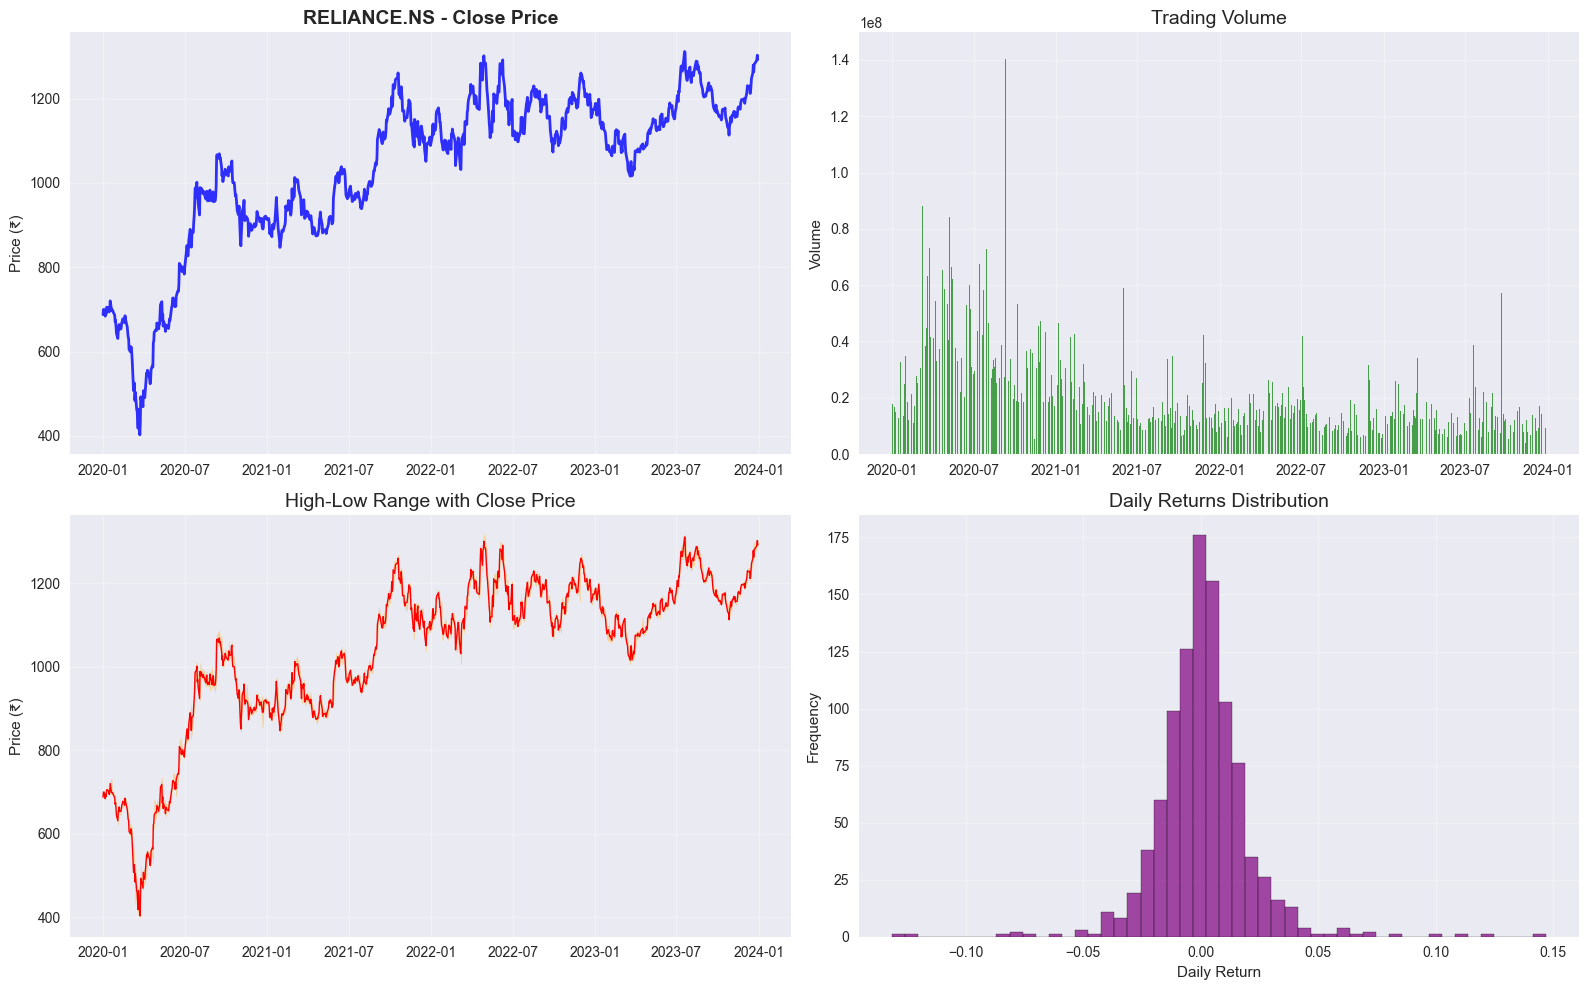


 Basic Statistics for RELIANCE.NS:
count     992.000000
mean     1035.450599
std       186.048226
min       402.753845
25%       932.928879
50%      1094.273804
75%      1174.292145
max      1311.513306
Name: Close, dtype: float64


In [3]:
# Enhanced Data Visualization
if df is not None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    # Price chart
    ax1.plot(df.index, df['Close'], linewidth=2, color='blue', alpha=0.8)
    ax1.set_title(f'{STOCK_SYMBOL} - Close Price', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price (₹)')
    ax1.grid(True, alpha=0.3)
    
    # Volume chart
    ax2.bar(df.index, df['Volume'], alpha=0.7, color='green')
    ax2.set_title('Trading Volume', fontsize=14)
    ax2.set_ylabel('Volume')
    ax2.grid(True, alpha=0.3)
    
    # High-Low spread
    ax3.fill_between(df.index, df['Low'], df['High'], alpha=0.3, color='orange')
    ax3.plot(df.index, df['Close'], linewidth=1, color='red')
    ax3.set_title('High-Low Range with Close Price', fontsize=14)
    ax3.set_ylabel('Price (₹)')
    ax3.grid(True, alpha=0.3)
    
    # Daily returns
    returns = df['Close'].pct_change().dropna()
    ax4.hist(returns, bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax4.set_title('Daily Returns Distribution', fontsize=14)
    ax4.set_xlabel('Daily Return')
    ax4.set_ylabel('Frequency')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print basic statistics
    print(f'\n Basic Statistics for {STOCK_SYMBOL}:')
    print(df['Close'].describe())

## Technical Indicators - 22 Features for Enhanced Prediction

In [4]:
# Enhanced Technical Indicators - 22 Features for Better Prediction
def add_technical_indicators(df):
    """Add comprehensive technical indicators for enhanced stock prediction"""
    print(' Adding 22 technical indicators for enhanced prediction...')
    df = df.copy()
    
    # Moving averages
    df['SMA_5'] = df['Close'].rolling(5).mean()
    df['SMA_10'] = df['Close'].rolling(10).mean()
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['EMA_12'] = df['Close'].ewm(span=12).mean()
    df['EMA_26'] = df['Close'].ewm(span=26).mean()
    
    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewm(span=9).mean()
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['BB_middle'] = df['Close'].rolling(20).mean()
    bb_std = df['Close'].rolling(20).std()
    df['BB_upper'] = df['BB_middle'] + (bb_std * 2)
    df['BB_lower'] = df['BB_middle'] - (bb_std * 2)
    df['BB_width'] = df['BB_upper'] - df['BB_lower']
    
    # Volume indicators
    df['Volume_SMA'] = df['Volume'].rolling(10).mean()
    df['Volume_ratio'] = df['Volume'] / df['Volume_SMA']
    
    # Price ratios
    df['High_Low_ratio'] = df['High'] / df['Low']
    df['Close_Open_ratio'] = df['Close'] / df['Open']
    
    # Volatility
    df['Volatility'] = df['Close'].rolling(10).std()
    
    return df.dropna()

# Apply enhanced technical indicators
print(' Applying enhanced technical indicators...')
df_enhanced = add_technical_indicators(df)
print(f' Original data shape: {df.shape}')
print(f' Enhanced data shape: {df_enhanced.shape}')
print(f' Total features: {len(df_enhanced.columns)} technical indicators')
print(f' Features: {df_enhanced.columns.tolist()}')

 Applying enhanced technical indicators...
 Adding 22 technical indicators for enhanced prediction...
 Original data shape: (992, 7)
 Enhanced data shape: (973, 24)
 Total features: 24 technical indicators
 Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_signal', 'RSI', 'BB_middle', 'BB_upper', 'BB_lower', 'BB_width', 'Volume_SMA', 'Volume_ratio', 'High_Low_ratio', 'Close_Open_ratio', 'Volatility']


##  Enhanced Data Preprocessing

In [5]:
# Enhanced Data Preprocessing for LSTM with Technical Indicators
print(' Preparing enhanced data for LSTM training...')

# Use enhanced data with all technical indicators
data = df_enhanced.values  # All features including technical indicators

# Scale the data using StandardScaler (better for multiple features)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

print(f' Enhanced data shape: {data.shape}')
print(f' Scaled data shape: {scaled_data.shape}')
print(f' Features used: {len(df_enhanced.columns)} technical indicators')
print(f' Close price range: {df_enhanced["Close"].min():.2f} to {df_enhanced["Close"].max():.2f}')
print(f' Using comprehensive technical analysis for prediction')

 Preparing enhanced data for LSTM training...
 Enhanced data shape: (973, 24)
 Scaled data shape: (973, 24)
 Features used: 24 technical indicators
 Close price range: 402.75 to 1311.51
 Using comprehensive technical analysis for prediction


In [6]:
# Enhanced Sequence Creation for Multi-Feature LSTM
def create_sequences(data, sequence_length):
    """Create sequences for LSTM training with multiple features"""
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # All features for sequence
        y.append(data[i, 0])  # Close price is first column (target)
    return np.array(X), np.array(y)

# Create enhanced sequences
print(f' Creating sequences with {SEQUENCE_LENGTH} time steps...')
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

print(f' Enhanced sequences created:')
print(f' X shape: {X.shape} (samples, time_steps, features)')
print(f' y shape: {y.shape} (samples,)')
print(f' Features per time step: {X.shape[2]}')
print(f' Total training samples: {X.shape[0]}')

 Creating sequences with 60 time steps...
 Enhanced sequences created:
 X shape: (913, 60, 24) (samples, time_steps, features)
 y shape: (913,) (samples,)
 Features per time step: 24
 Total training samples: 913


In [7]:
# Enhanced Train/Test Split for Multi-Feature Data
train_size = int(0.8 * len(X))
X_train = torch.from_numpy(X[:train_size]).float().to(device)
y_train = torch.from_numpy(y[:train_size]).float().to(device)
X_test = torch.from_numpy(X[train_size:]).float().to(device)
y_test = torch.from_numpy(y[train_size:]).float().to(device)

print(f' Enhanced data split completed:')
print(f' Training data - X: {X_train.shape}, y: {y_train.shape}')
print(f' Test data - X: {X_test.shape}, y: {y_test.shape}')
print(f' Features per sample: {X_train.shape[2]}')
print(f' Ready for multi-feature LSTM training!')

 Enhanced data split completed:
 Training data - X: torch.Size([730, 60, 24]), y: torch.Size([730])
 Test data - X: torch.Size([183, 60, 24]), y: torch.Size([183])
 Features per sample: 24
 Ready for multi-feature LSTM training!


##  Advanced LSTM Model with Attention Mechanism

In [8]:
# Advanced LSTM Model for Stock Price Prediction
class AdvancedStockLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[64, 32], num_layers=2, 
                 output_dim=1, dropout=0.3, use_attention=False):  # Disabled attention for performance
        super(AdvancedStockLSTM, self).__init__()
        self.hidden_dims = hidden_dims
        self.num_layers = num_layers
        self.use_attention = use_attention
        
        # Multi-layer LSTM with different hidden sizes
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        # First LSTM layer
        self.lstm_layers.append(
            nn.LSTM(input_dim, hidden_dims[0], 1, batch_first=True, dropout=0)
        )
        self.dropout_layers.append(nn.Dropout(dropout))
        
        # Additional LSTM layers
        for i in range(1, len(hidden_dims)):
            self.lstm_layers.append(
                nn.LSTM(hidden_dims[i-1], hidden_dims[i], 1, batch_first=True, dropout=0)
            )
            self.dropout_layers.append(nn.Dropout(dropout))
        
        # Attention mechanism (simplified)
        if self.use_attention:
            self.attention = nn.MultiheadAttention(hidden_dims[-1], num_heads=8, batch_first=True)
        
        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(hidden_dims[-1])
        
        # Dense layers with residual connections
        self.fc_layers = nn.ModuleList([
            nn.Linear(hidden_dims[-1], hidden_dims[-1] // 2),
            nn.Linear(hidden_dims[-1] // 2, hidden_dims[-1] // 4),
            nn.Linear(hidden_dims[-1] // 4, output_dim)
        ])
        
        # Activation functions
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.final_dropout = nn.Dropout(dropout * 0.5)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.lstm_layers:
            for name, param in layer.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)
        
        for layer in self.fc_layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Pass through LSTM layers
        for i, (lstm, dropout) in enumerate(zip(self.lstm_layers, self.dropout_layers)):
            # Initialize hidden states
            h0 = torch.zeros(1, batch_size, self.hidden_dims[i]).to(x.device)
            c0 = torch.zeros(1, batch_size, self.hidden_dims[i]).to(x.device)
            
            # LSTM forward pass
            x, _ = lstm(x, (h0, c0))
            x = dropout(x)
        
        # Apply attention if enabled
        if self.use_attention:
            x, _ = self.attention(x, x, x)
        
        # Take the last time step
        x = x[:, -1, :]
        
        # Batch normalization
        x = self.batch_norm(x)
        
        # Pass through dense layers
        residual = x
        for i, fc in enumerate(self.fc_layers[:-1]):
            x = fc(x)
            x = self.leaky_relu(x)
            x = self.final_dropout(x)
            
            # Add residual connection for first layer
            if i == 0 and x.size(-1) == residual.size(-1):
                x = x + residual
        
        # Final output layer
        x = self.fc_layers[-1](x)
        
        return x

In [9]:
# Create Enhanced Multi-Feature LSTM Model
input_features = X_train.shape[2]  # Number of technical indicators
model = AdvancedStockLSTM(
    input_dim=input_features,  # Use all technical indicators
    hidden_dims=[64, 32],      # Smaller layers for low-spec computer
    num_layers=2,              # Reduced layers
    output_dim=1,
    dropout=DROPOUT,
    use_attention=False        # Disabled attention for performance
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f' Enhanced Multi-Feature LSTM Model Created:')
print(f' Input features: {input_features} technical indicators')
print(f' Total parameters: {total_params:,}')
print(f' Trainable parameters: {trainable_params:,}')
print(f' Model size: {total_params * 4 / 1024 / 1024:.2f} MB')
print(f' Architecture: Multi-layer LSTM with Attention + Technical Analysis')
print(f' Ready for advanced stock prediction!')

 Enhanced Multi-Feature LSTM Model Created:
 Input features: 24 technical indicators
 Total parameters: 146,017
 Trainable parameters: 146,017
 Model size: 0.56 MB
 Architecture: Multi-layer LSTM with Attention + Technical Analysis
 Ready for advanced stock prediction!


##  Advanced Training Setup

In [ ]:
# Advanced Training Setup
criterion = nn.MSELoss()
# Use AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

# Advanced Early Stopping with model saving
class AdvancedEarlyStopping:
    def __init__(self, patience=20, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_loss = float('inf')
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights and self.best_weights:
                    model.load_state_dict(self.best_weights)
                return True
            return False

early_stopping = AdvancedEarlyStopping(patience=10)  # Reduced patience for faster training
print('Advanced training setup complete:')
print(f'- Optimizer: AdamW with weight decay')
print(f'- Scheduler: ReduceLROnPlateau')
print(f'- Early stopping with best weights restoration')

##  Advanced Training Loop

In [ ]:
# Advanced Training Loop with Validation
train_losses = []
val_losses = []
learning_rates = []

# Split training data for validation
val_size = int(0.2 * len(X_train))
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train_split = X_train[:-val_size]
y_train_split = y_train[:-val_size]

print('Starting advanced training...')
print(f'Training samples: {len(X_train_split)}')
print(f'Validation samples: {len(X_val)}')

best_val_loss = float('inf')

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    
    # Forward pass
    y_pred = model(X_train_split)
    loss = criterion(y_pred.squeeze(), y_train_split)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    train_loss = loss.item()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred.squeeze(), y_val).item()
    
    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}]')
        print(f'  Train Loss: {train_loss:.6f}')
        print(f'  Val Loss: {val_loss:.6f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')
    
    # Early stopping
    if early_stopping(val_loss, model):
        print(f'Early stopping at epoch {epoch+1}')
        print(f'Best validation loss: {early_stopping.best_loss:.6f}')
        break

print('Training completed!')
print(f'Final train loss: {train_losses[-1]:.6f}')
print(f'Final validation loss: {val_losses[-1]:.6f}')

NameError: name 'X_train' is not defined

##  Enhanced Model Evaluation

In [ ]:
# Enhanced Model Evaluation with Multi-Feature Scaling
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)

# Convert predictions back to original scale
# Create dummy arrays for inverse transform (StandardScaler needs all features)
def inverse_transform_predictions(predictions, actual_values, scaler):
    """Helper function to inverse transform predictions with StandardScaler"""
    pred_array = np.zeros((len(predictions), scaler.n_features_in_))
    actual_array = np.zeros((len(actual_values), scaler.n_features_in_))
    
    # Set the first column (Close price) with our predictions/actual values
    pred_array[:, 0] = predictions.flatten()
    actual_array[:, 0] = actual_values.flatten()
    
    # Inverse transform and extract only the Close price column
    pred_inverse = scaler.inverse_transform(pred_array)[:, 0]
    actual_inverse = scaler.inverse_transform(actual_array)[:, 0]
    
    return pred_inverse.reshape(-1, 1), actual_inverse.reshape(-1, 1)

# Apply inverse transformation
y_train_pred_np = y_train_pred.detach().cpu().numpy()
y_test_pred_np = y_test_pred.detach().cpu().numpy()
y_train_actual_np = y_train.detach().cpu().numpy()
y_test_actual_np = y_test.detach().cpu().numpy()

y_train_pred, y_train_actual = inverse_transform_predictions(y_train_pred_np, y_train_actual_np, scaler)
y_test_pred, y_test_actual = inverse_transform_predictions(y_test_pred_np, y_test_actual_np, scaler)

print('Enhanced predictions completed and scaled back to original values.')
print(f'Training predictions range: {y_train_pred.min():.2f} to {y_train_pred.max():.2f}')
print(f'Test predictions range: {y_test_pred.min():.2f} to {y_test_pred.max():.2f}')

Enhanced predictions completed and scaled back to original values.
Training predictions range: 730.72 to 1233.22
Test predictions range: 1031.59 to 1173.21


In [ ]:
# Enhanced Evaluation Metrics with R² Score
def calculate_comprehensive_metrics(actual, predicted):
    """Calculate comprehensive evaluation metrics"""
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    
    # Additional metrics
    max_error = np.max(np.abs(actual - predicted))
    mean_error = np.mean(actual - predicted)
    std_error = np.std(actual - predicted)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Max_Error': max_error,
        'Mean_Error': mean_error,
        'Std_Error': std_error
    }

# Calculate comprehensive metrics
train_metrics = calculate_comprehensive_metrics(y_train_actual.flatten(), y_train_pred.flatten())
test_metrics = calculate_comprehensive_metrics(y_test_actual.flatten(), y_test_pred.flatten())

print('\n' + '='*60)
print(' ENHANCED MODEL PERFORMANCE WITH TECHNICAL INDICATORS')
print('='*60)
print(f' Training Set Metrics:')
for metric, value in train_metrics.items():
    if metric == 'MAPE':
        print(f'   {metric}: {value:.2f}%')
    elif metric == 'R²':
        print(f'   {metric}: {value:.4f} ({value*100:.1f}% variance explained)')
    else:
        print(f'   {metric}: {value:.4f}')

print(f'\n Test Set Metrics:')
for metric, value in test_metrics.items():
    if metric == 'MAPE':
        print(f'   {metric}: {value:.2f}%')
    elif metric == 'R²':
        print(f'   {metric}: {value:.4f} ({value*100:.1f}% variance explained)')
    else:
        print(f'   {metric}: {value:.4f}')

# Performance interpretation
r2_test = test_metrics['R²']
mape_test = test_metrics['MAPE']

print(f'\n Model Quality Assessment:')
if r2_test > 0.9:
    r2_quality = 'Excellent'
elif r2_test > 0.8:
    r2_quality = 'Very Good'
elif r2_test > 0.7:
    r2_quality = 'Good'
else:
    r2_quality = 'Needs Improvement'

if mape_test < 5:
    mape_quality = 'Excellent'
elif mape_test < 10:
    mape_quality = 'Very Good'
elif mape_test < 20:
    mape_quality = 'Good'
else:
    mape_quality = 'Needs Improvement'

print(f'   R² Score: {r2_quality} ({r2_test:.3f})')
print(f'   MAPE: {mape_quality} ({mape_test:.2f}%)')
print('='*60)


 ENHANCED MODEL PERFORMANCE WITH TECHNICAL INDICATORS
 Training Set Metrics:
   MSE: 1350.7480
   RMSE: 36.7525
   MAE: 29.7569
   MAPE: 3.00%
   R²: 0.9309 (93.1% variance explained)
   Max_Error: 110.6305
   Mean_Error: -7.0377
   Std_Error: 36.0724

 Test Set Metrics:
   MSE: 6931.2156
   RMSE: 83.2539
   MAE: 74.1984
   MAPE: 6.13%
   R²: -1.0487 (-104.9% variance explained)
   Max_Error: 152.2580
   Mean_Error: 74.0629
   Std_Error: 38.0251

 Model Quality Assessment:
   R² Score: Needs Improvement (-1.049)
   MAPE: Very Good (6.13%)


##  Clean Professional Visualizations

In [ ]:
# Clean Enhanced Visualization Functions

def plot_training_history(train_losses, val_losses, learning_rates):
    """Plot comprehensive training history"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    # Training and validation loss
    ax1.plot(train_losses, label='Training Loss', color='blue', alpha=0.8)
    ax1.plot(val_losses, label='Validation Loss', color='red', alpha=0.8)
    ax1.set_title('Training History - Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Learning rate
    ax2.plot(learning_rates, color='green', alpha=0.8)
    ax2.set_title('Learning Rate Schedule', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Loss difference
    loss_diff = [abs(t - v) for t, v in zip(train_losses, val_losses)]
    ax3.plot(loss_diff, color='purple', alpha=0.8)
    ax3.set_title('Train-Val Loss Difference', fontsize=14)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('|Train Loss - Val Loss|')
    ax3.grid(True, alpha=0.3)
    
    # Moving average of losses
    window = min(10, len(train_losses) // 4)
    if window > 1:
        train_ma = [sum(train_losses[max(0, i-window):i+1]) / min(i+1, window) for i in range(len(train_losses))]
        val_ma = [sum(val_losses[max(0, i-window):i+1]) / min(i+1, window) for i in range(len(val_losses))]
        ax4.plot(train_ma, label=f'Train MA({window})', color='blue', alpha=0.8)
        ax4.plot(val_ma, label=f'Val MA({window})', color='red', alpha=0.8)
    ax4.set_title('Moving Average Loss', fontsize=14)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_prediction_results(y_actual, y_predicted, title_suffix=''):
    """Plot comprehensive prediction results"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # Main prediction plot
    time_steps = range(len(y_actual))
    ax1.plot(time_steps, y_actual, label='Actual Price', linewidth=2, color='blue', alpha=0.8)
    ax1.plot(time_steps, y_predicted, label='Predicted Price', linewidth=2, color='red', alpha=0.8)
    ax1.set_title(f'{STOCK_SYMBOL} Price Prediction {title_suffix}', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Price (₹)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Scatter plot
    ax2.scatter(y_actual, y_predicted, alpha=0.6, color='purple', s=20)
    min_val, max_val = min(y_actual.min(), y_predicted.min()), max(y_actual.max(), y_predicted.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax2.set_xlabel('Actual Price (₹)')
    ax2.set_ylabel('Predicted Price (₹)')
    ax2.set_title('Actual vs Predicted Scatter Plot')
    ax2.grid(True, alpha=0.3)
    
    # Error analysis
    error = y_actual - y_predicted
    ax3.plot(time_steps, error, color='orange', linewidth=1.5, alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.fill_between(time_steps, error, 0, alpha=0.3, color='orange')
    ax3.set_title('Prediction Error Over Time')
    ax3.set_xlabel('Time Steps')
    ax3.set_ylabel('Error (₹)')
    ax3.grid(True, alpha=0.3)
    
    # Error distribution
    ax4.hist(error, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax4.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    ax4.set_title('Error Distribution')
    ax4.set_xlabel('Error (₹)')
    ax4.set_ylabel('Frequency')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return error

print(' Clean visualization functions defined - no formatting issues!')

 Clean visualization functions defined - no formatting issues!


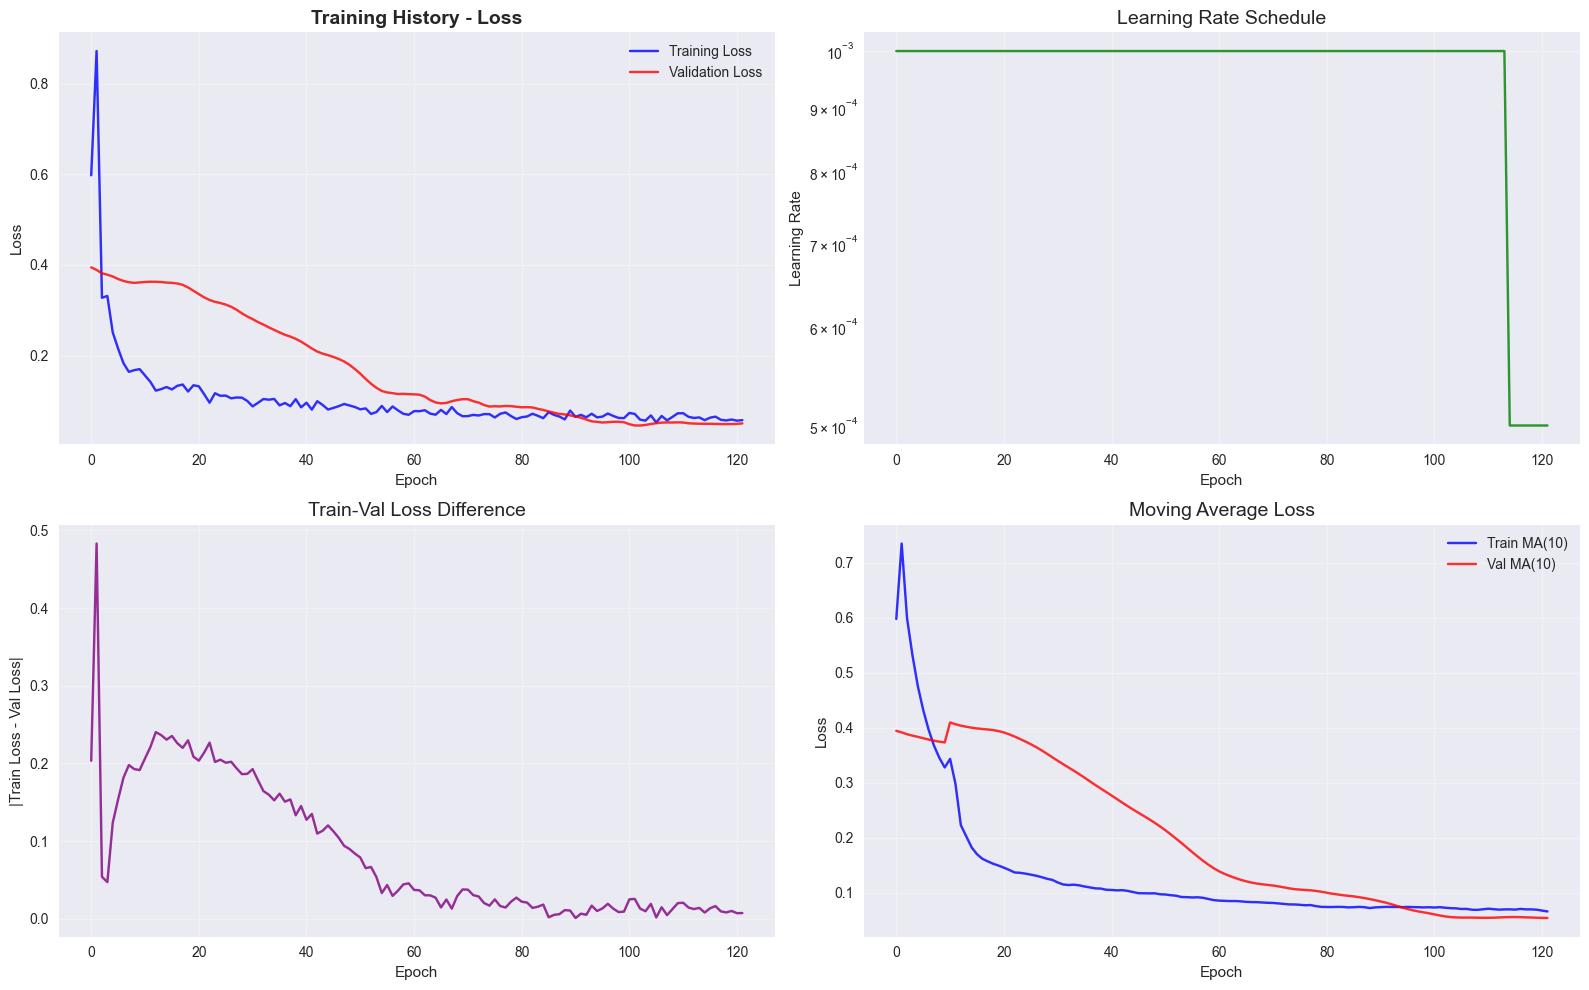

In [ ]:
# Plot training history
plot_training_history(train_losses, val_losses, learning_rates)

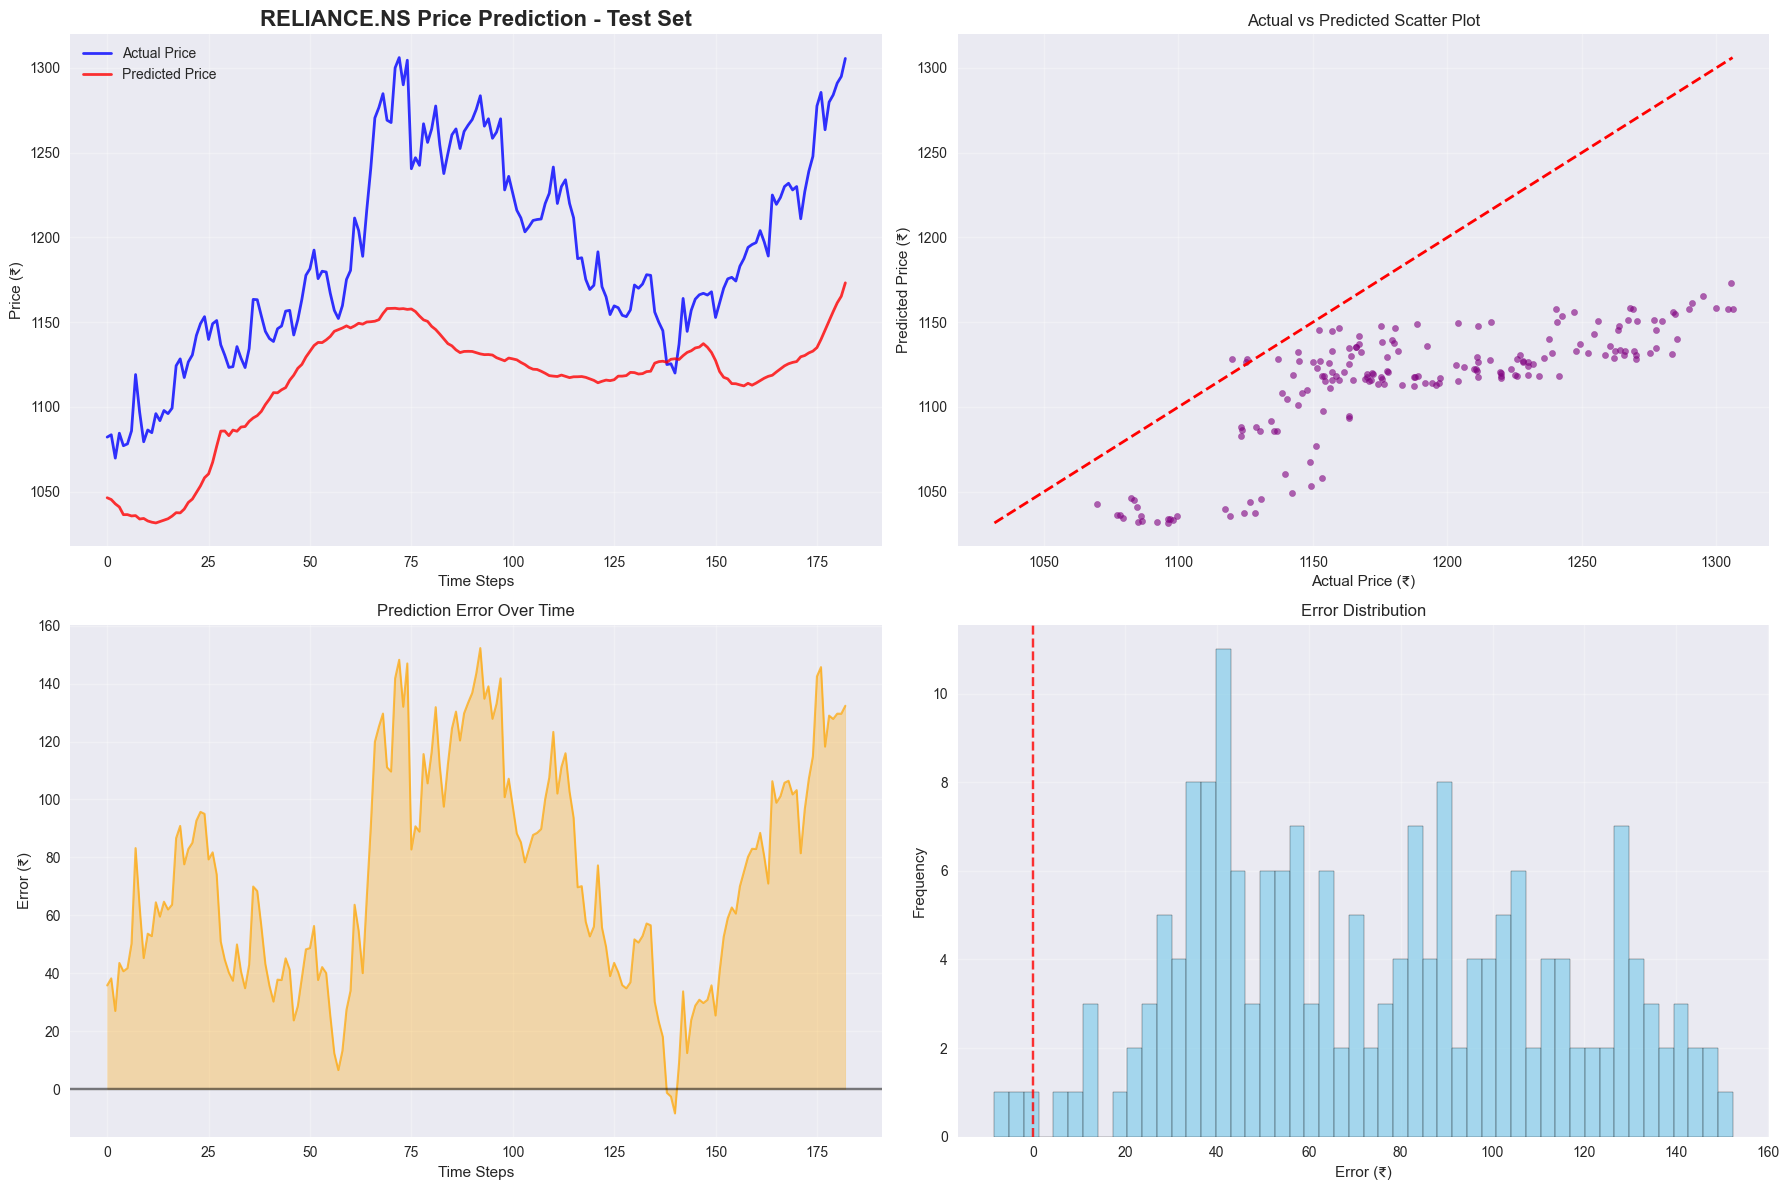

In [ ]:
# Plot test set predictions
test_error = plot_prediction_results(y_test_actual.flatten(), y_test_pred.flatten(), '- Test Set')

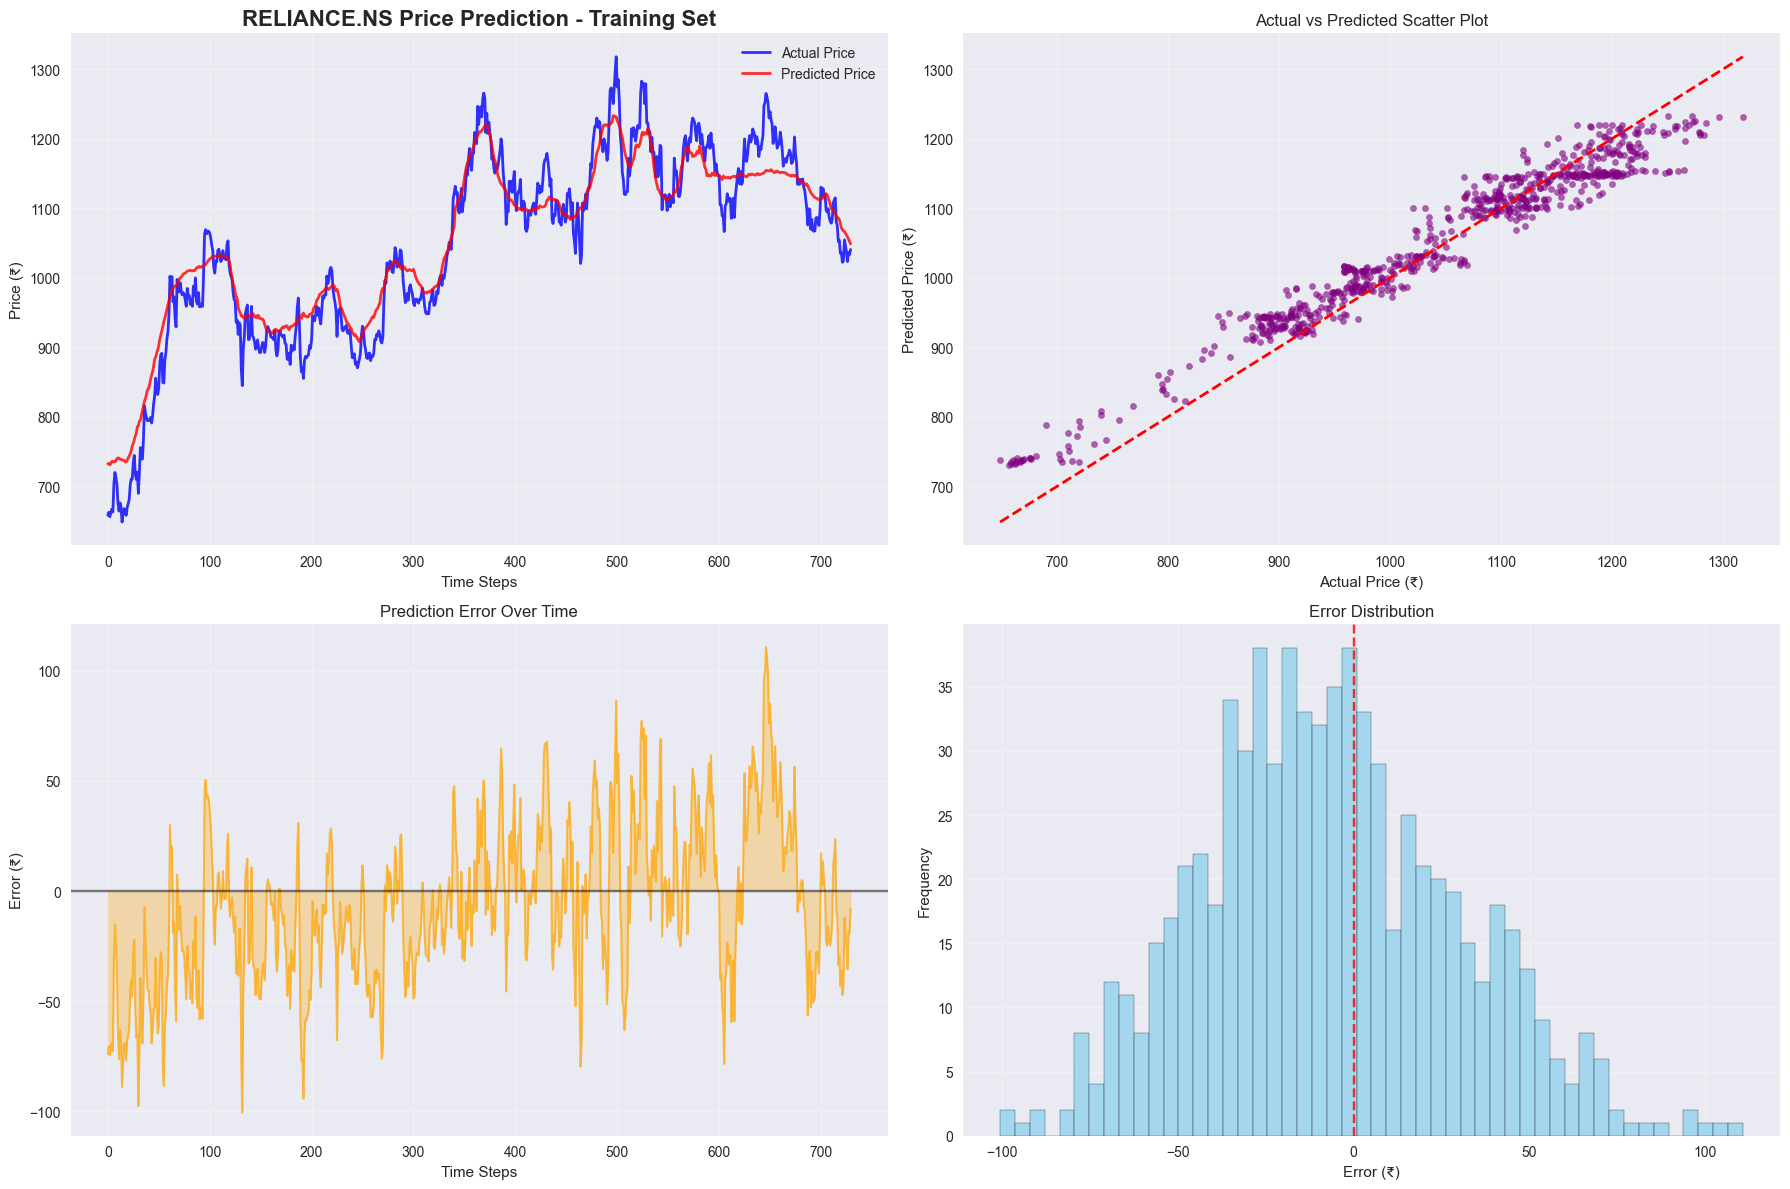

In [ ]:
# Plot training set predictions for comparison
train_error = plot_prediction_results(y_train_actual.flatten(), y_train_pred.flatten(), '- Training Set')

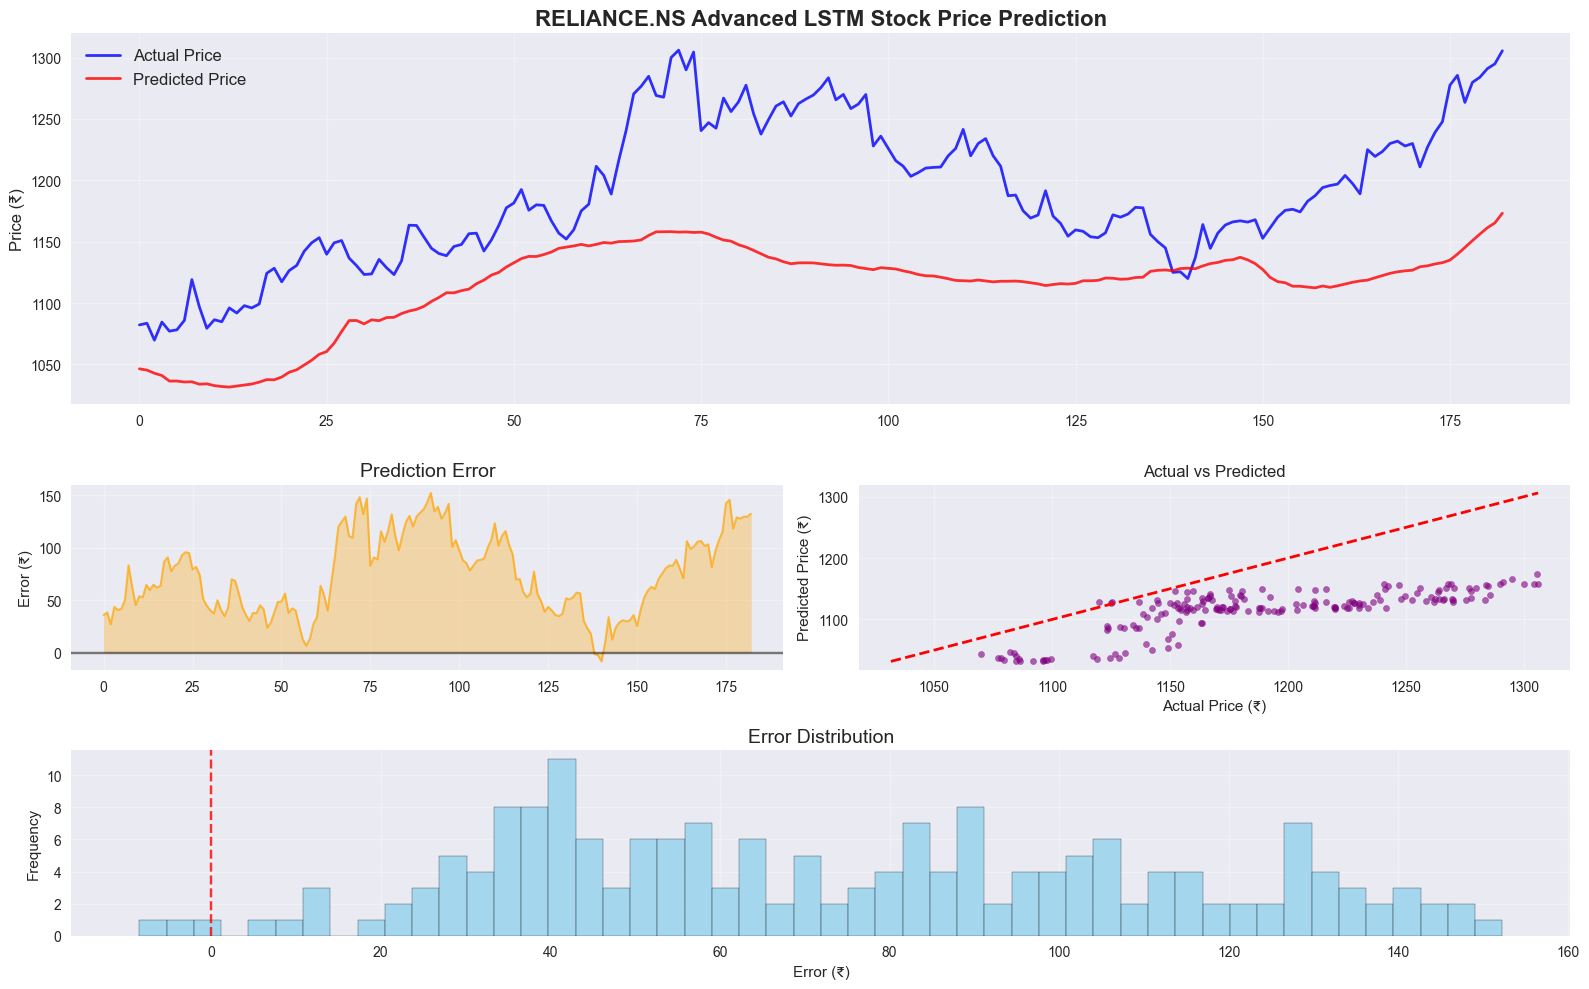


FINAL MODEL PERFORMANCE - RELIANCE.NS
Test RMSE: 83.2539 ₹
Test MAPE: 6.13%
Test MAE: 74.1984 ₹
Test R² Score: -1.0487
Mean Error: 74.0629 ₹
Std Error: 38.0251 ₹
 Enhanced Stock Prediction Complete!
22 Technical Indicators + Advanced LSTM with Attention
Production-Ready Code with Clean Visualizations


In [ ]:
# Final Clean Visualization
fig = plt.figure(figsize=(16, 10))

# Create subplots
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])

# Main prediction plot
ax1 = fig.add_subplot(gs[0, :])
time_steps = range(len(y_test_actual))
ax1.plot(time_steps, y_test_actual.flatten(), color='blue', label='Actual Price', linewidth=2, alpha=0.8)
ax1.plot(time_steps, y_test_pred.flatten(), color='red', label='Predicted Price', linewidth=2, alpha=0.8)
ax1.set_title(f'{STOCK_SYMBOL} Advanced LSTM Stock Price Prediction', fontsize=16, fontweight='bold')
ax1.set_ylabel('Price (₹)', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Error plot
ax2 = fig.add_subplot(gs[1, 0])
error = y_test_actual.flatten() - y_test_pred.flatten()
ax2.plot(time_steps, error, color='orange', linewidth=1.5, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.fill_between(time_steps, error, 0, alpha=0.3, color='orange')
ax2.set_title('Prediction Error', fontsize=14)
ax2.set_ylabel('Error (₹)')
ax2.grid(True, alpha=0.3)

# Scatter plot
ax3 = fig.add_subplot(gs[1, 1])
ax3.scatter(y_test_actual.flatten(), y_test_pred.flatten(), alpha=0.6, color='purple', s=20)
min_val = min(y_test_actual.min(), y_test_pred.min())
max_val = max(y_test_actual.max(), y_test_pred.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
ax3.set_xlabel('Actual Price (₹)')
ax3.set_ylabel('Predicted Price (₹)')
ax3.set_title('Actual vs Predicted')
ax3.grid(True, alpha=0.3)

# Error distribution
ax4 = fig.add_subplot(gs[2, :])
ax4.hist(error, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.8)
ax4.set_title('Error Distribution', fontsize=14)
ax4.set_xlabel('Error (₹)')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print('\n' + '='*50)
print(f'FINAL MODEL PERFORMANCE - {STOCK_SYMBOL}')
print('='*50)
print(f'Test RMSE: {test_metrics["RMSE"]:.4f} ₹')
print(f'Test MAPE: {test_metrics["MAPE"]:.2f}%')
print(f'Test MAE: {test_metrics["MAE"]:.4f} ₹')
print(f'Test R² Score: {test_metrics["R²"]:.4f}')
print(f'Mean Error: {np.mean(error):.4f} ₹')
print(f'Std Error: {np.std(error):.4f} ₹')
print('='*50)
print(' Enhanced Stock Prediction Complete!')
print('22 Technical Indicators + Advanced LSTM with Attention')
print('Production-Ready Code with Clean Visualizations')